In [1]:
# Create a LSTM model to predict the next bit of a LFSR
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers
from tqdm import tqdm


def create_data(
    num_samples=10000, initial_key1=None, initial_key2=None, ln=5, output_ln=5
):
    if initial_key1 is None:
        initial_key1 = np.random.randint(0, 2, 5)
        print("Initial key 1: ", initial_key1)
    if initial_key2 is None:
        initial_key2 = np.random.randint(0, 2, 5)
        print("Initial key 2: ", initial_key2)

    # data = initial_key
    key1 = initial_key1
    key2 = initial_key2
    x = []
    y = []
    # st = set()
    data = []
    for _ in range(num_samples):
        nxt1 = key1[0] ^ key1[1]
        nxt2 = key2[0] ^ key2[2]
        data.append(nxt1 ^ nxt2)
        if len(data) >= ln + output_ln:
            x.append(data[-(ln + output_ln) : -output_ln])
            # st.add(tuple(data[-10 * ln : -9 * ln]))
            y.append(data[-output_ln:])
        key1 = np.roll(key1, -1)
        key2 = np.roll(key2, -1)
        key1[-1] = nxt1
        key2[-1] = nxt2
    # print("Unique samples: ", len(st))
    return np.array(x), np.array(y)
ln = 10


2024-05-06 10:07:21.174877: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-06 10:07:31.684248: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/TensorRT-8.4.0.6//lib:/usr/local/cuda-11.6/lib64:/usr/local/apps/python-3.10.2/lib:/home2/shivam.sood/.mujoco/mujoco210/bin:/home2/shivam.sood/.mujoco/mujoco210/bin:/usr/local/apps/cuDNN/8.4.0-cuda-11.6/lib
2024-05-06 10:07:31.685025: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.

In [2]:
b_list = [200, 100, 50, 20, 1]
test_len = [1000, 1000, 100, 100, 10]
pred_len = 500
import math

def create_model(b):
    model = tf.keras.models.Sequential(
        [
            tf.keras.layers.Embedding(2, 128, input_length=10),
            tf.keras.layers.Flatten(),
            tf.keras.layers.Dense(1000, activation="relu"),
            tf.keras.layers.Dense(b, activation="sigmoid"),
            # tf.keras.layers.Flatten(),
        ]
    )
    opt = tf.keras.optimizers.Adam()
    model.compile(
        optimizer=opt, loss="binary_crossentropy", metrics=["binary_accuracy"]
    )

    return model


def find_groud_truth(pred_len, Y_test, i, b):
    ground_truth = []
    
    div, rem = divmod(pred_len, b)
    rng = div + (1 if rem else 0)
    for j in range(rng):
        ground_truth = np.concatenate((ground_truth, Y_test[i + (j * b)]))
    ground_truth = np.array(ground_truth)
    return ground_truth[:pred_len]


def get_final_pred(pred_len, b, model, X_test, i):
    final_pred = []
    current = X_test[i]
    div, rem = divmod(pred_len, b)
    rng = div + (1 if rem else 0)
    for _ in range(rng):
        pred = model.predict(current.reshape(1, ln), verbose=0)
        pred = np.rint(pred)
        final_pred = np.concatenate((np.array(final_pred), pred[0]))
        if len(final_pred) < ln:
            current = np.concatenate(
                (X_test[i, -(ln - final_pred.shape[0]) :], final_pred)
            )
        else:
            current = final_pred[-ln:]

    final_pred = np.array(final_pred)
    return final_pred[:pred_len]


def find_acc(b_list, test_len, pred_len, training_len):
    acc_list = []
    for t_len, b in zip(test_len,b_list):
        model = create_model(b)
        # model.summary()
        X, Y = create_data(
        10000,
        ln=ln,
        output_ln=b,
        initial_key1=np.array([1, 0, 1, 0, 1]),
        initial_key2=np.array([0, 0, 1, 1, 1]),
    )
        X_train, Y_train = X[: training_len - ln - b], Y[: training_len - ln - b]
        X_test, Y_test = X[training_len - ln - b:], Y[training_len - ln - b:]
        es = tf.keras.callbacks.EarlyStopping(
        monitor="val_loss",
        patience=100,
        verbose=1,
        mode="auto",
        restore_best_weights=True,
        start_from_epoch=1000,
    )
        print("b = ", b)
        model.fit(
        X_train,
        Y_train,
        epochs=1000,
        validation_data=(X_test, Y_test),
        batch_size=256,
        verbose=2,
        # callbacks=[es],
    )
        
        print("Test Accuracy:", model.evaluate(X_test, Y_test)[1])

        test_indices = np.random.choice(X_test.shape[0] - (pred_len + 1), t_len)
        total_acc = 0
        div, rem = divmod(pred_len, b)
        rng = div + (1 if rem else 0)
        total_accs = np.zeros(rng)
        pbar = tqdm(test_indices)
        for ind, i in enumerate(pbar):
            acc = 0
            ground_truth = find_groud_truth(pred_len, Y_test, i, b)
            final_pred = get_final_pred(pred_len, b, model, X_test, i)
            
            for j in range(rng):
                
                total_accs[j] += np.sum(final_pred[j*b:min((j+1)*b, pred_len-1)] == ground_truth[j*b:min((j+1)*b, pred_len-1)]) / (b if (j+1)*b <= pred_len else pred_len - j*b)
            acc = np.sum(final_pred == ground_truth) / pred_len
            total_acc += acc
            pbar.set_description(f"Current accuracy: {total_acc / (ind + 1):.2f}")
            # print("Current accuracy: ", acc / (i + 1), end="\r")
            
        print("Average accuracy: ", total_acc / t_len)
        print("Average Accuracy by Block: ", total_accs / t_len)
        acc_list.append(total_acc / t_len)
        print("--------------------------------")
    return acc_list

def find_acc2():
    acc_list = []
    b= 1
    for training_len in range(100, 501, 100):
        model = create_model(1)
        # model.summary()
        X, Y = create_data(
        10000,
        ln=ln,
        output_ln=1,
        initial_key1=np.array([1, 0, 1, 0, 1]),
        initial_key2=np.array([0, 0, 1, 1, 1]),
    )
        print(f"Training Length: {training_len}")
        X_train, Y_train = X[: training_len - ln - b], Y[: training_len - ln - b]
        X_test, Y_test = X[training_len - ln - b:], Y[training_len - ln - b:]
        model.fit(
        X_train,
        Y_train,
        epochs=500,
        validation_data=(X_test, Y_test),
        batch_size=256,
        verbose=2,
        # callbacks=[es],
    )
        acc = model.evaluate(X_test, Y_test)[1]
        print("Test Accuracy:", acc)

        acc_list.append(acc)
        print("--------------------------------")
    return acc_list

def find_acc3():
    acc_list = []
    b= 1
    X, Y = create_data(
        10000,
        ln=ln,
        output_ln=1,
        initial_key1=np.array([1, 0, 1, 0, 1]),
        initial_key2=np.array([0, 0, 1, 1, 1]),
    )
    X_train, Y_train = X[: 300 - ln - b], Y[: 300 - ln - b]
    X_test, Y_test = X[300 - ln - b:], Y[300 - ln - b:]
    model = create_model(1)
    model.fit(
        X_train,
        Y_train,
        epochs=2000,
        validation_data=(X_test, Y_test),
        batch_size=256,
        verbose=2,
        # callbacks=[es],
    )
    pred_len = 500
    t_len = 30
    total_accs = np.zeros(pred_len)
    test_indices = np.random.choice(X_test.shape[0] - (pred_len + 1), t_len)
    pbar = tqdm(test_indices)
    for ind, i in enumerate(pbar):
        
        # model.summary()
        ground_truth = find_groud_truth(pred_len, Y_test, i, b)
        final_pred = get_final_pred(pred_len, b, model, X_test, i)
        
        for j in range(pred_len):
            total_accs[j] += np.sum(final_pred[:j+1] == ground_truth[:j+1]) / (j + 1)

        # acc_list.append(acc)
        # print("--------------------------------")
    return total_accs / t_len

# acc_500 = find_acc(b_list, test_len, pred_len, 500)

In [8]:


acc_500 = find_acc(b_list, test_len, pred_len, 500)

b =  200
297/297 [==============================] - 1s 3ms/step - loss: 1.4481 - binary_accuracy: 0.7409
Test Accuracy: 0.7408983707427979


Current accuracy: 0.64: 100%|███████████████| 1000/1000 [02:30<00:00,  6.63it/s]


Average accuracy:  0.6399359999999992
Average Accuracy by Block:  [0.75203  0.593035 0.50497 ]
--------------------------------
b =  100
297/297 [==============================] - 1s 3ms/step - loss: 0.5842 - binary_accuracy: 0.8702
Test Accuracy: 0.8702241778373718


Current accuracy: 0.70: 100%|███████████████| 1000/1000 [04:10<00:00,  4.00it/s]


Average accuracy:  0.6958179999999998
Average Accuracy by Block:  [0.8769  0.76044 0.69339 0.61425 0.52876]
--------------------------------
b =  50
297/297 [==============================] - 1s 3ms/step - loss: 0.0714 - binary_accuracy: 0.9766
Test Accuracy: 0.9766026139259338


Current accuracy: 0.79: 100%|█████████████████| 100/100 [00:51<00:00,  1.93it/s]


Average accuracy:  0.7920199999999995
Average Accuracy by Block:  [0.9752 0.9088 0.8888 0.8448 0.8144 0.7706 0.7372 0.6934 0.6536 0.6194]
--------------------------------
b =  20
297/297 [==============================] - 1s 3ms/step - loss: 0.0101 - binary_accuracy: 0.9968
Test Accuracy: 0.996763288974762


Current accuracy: 0.86: 100%|█████████████████| 100/100 [02:04<00:00,  1.25s/it]


Average accuracy:  0.8580199999999999
Average Accuracy by Block:  [0.9985 0.992  0.9835 0.952  0.9325 0.9035 0.882  0.88   0.869  0.8725
 0.8555 0.8635 0.8505 0.8465 0.846  0.837  0.8215 0.8195 0.8045 0.791
 0.782  0.771  0.7705 0.77   0.723 ]
--------------------------------
b =  1
297/297 [==============================] - 1s 3ms/step - loss: 2.2022e-04 - binary_accuracy: 1.0000
Test Accuracy: 1.0


Current accuracy: 1.00: 100%|███████████████████| 10/10 [04:07<00:00, 24.78s/it]

Average accuracy:  1.0
Average Accuracy by Block:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.


In [9]:
print(acc_500)

[0.6399359999999992, 0.6958179999999998, 0.7920199999999995, 0.8580199999999999, 1.0]


In [10]:
acc_400 = find_acc(b_list, test_len, pred_len, 400)

b =  200
Epoch 1/1000
1/1 - 1s - loss: 0.6934 - binary_accuracy: 0.4971 - val_loss: 0.6932 - val_binary_accuracy: 0.5033 - 1s/epoch - 1s/step
Epoch 2/1000
1/1 - 0s - loss: 0.6921 - binary_accuracy: 0.5329 - val_loss: 0.6933 - val_binary_accuracy: 0.5011 - 122ms/epoch - 122ms/step
Epoch 3/1000
1/1 - 0s - loss: 0.6909 - binary_accuracy: 0.5447 - val_loss: 0.6936 - val_binary_accuracy: 0.5007 - 125ms/epoch - 125ms/step
Epoch 4/1000
1/1 - 0s - loss: 0.6897 - binary_accuracy: 0.5475 - val_loss: 0.6941 - val_binary_accuracy: 0.5006 - 115ms/epoch - 115ms/step
Epoch 5/1000
1/1 - 0s - loss: 0.6884 - binary_accuracy: 0.5488 - val_loss: 0.6951 - val_binary_accuracy: 0.5008 - 132ms/epoch - 132ms/step
Epoch 6/1000
1/1 - 0s - loss: 0.6871 - binary_accuracy: 0.5499 - val_loss: 0.6966 - val_binary_accuracy: 0.5008 - 128ms/epoch - 128ms/step
Epoch 7/1000
1/1 - 0s - loss: 0.6861 - binary_accuracy: 0.5503 - val_loss: 0.6985 - val_binary_accuracy: 0.5013 - 128ms/epoch - 128ms/step
Epoch 8/1000
1/1 - 0s - 

Current accuracy: 0.57: 100%|███████████████| 1000/1000 [02:31<00:00,  6.59it/s]


Average accuracy:  0.5669060000000009
Average Accuracy by Block:  [0.66026  0.507475 0.49389 ]
--------------------------------
b =  100
Epoch 1/1000
2/2 - 1s - loss: 0.6932 - binary_accuracy: 0.5013 - val_loss: 0.6933 - val_binary_accuracy: 0.5000 - 1s/epoch - 568ms/step
Epoch 2/1000
2/2 - 0s - loss: 0.6908 - binary_accuracy: 0.5382 - val_loss: 0.6942 - val_binary_accuracy: 0.5006 - 121ms/epoch - 60ms/step
Epoch 3/1000
2/2 - 0s - loss: 0.6895 - binary_accuracy: 0.5394 - val_loss: 0.6955 - val_binary_accuracy: 0.5006 - 112ms/epoch - 56ms/step
Epoch 4/1000
2/2 - 0s - loss: 0.6885 - binary_accuracy: 0.5411 - val_loss: 0.6966 - val_binary_accuracy: 0.5007 - 117ms/epoch - 59ms/step
Epoch 5/1000
2/2 - 0s - loss: 0.6878 - binary_accuracy: 0.5418 - val_loss: 0.6974 - val_binary_accuracy: 0.5006 - 121ms/epoch - 60ms/step
Epoch 6/1000
2/2 - 0s - loss: 0.6871 - binary_accuracy: 0.5431 - val_loss: 0.6974 - val_binary_accuracy: 0.5010 - 131ms/epoch - 66ms/step
Epoch 7/1000
2/2 - 0s - loss: 0.6862 

Current accuracy: 0.61: 100%|███████████████| 1000/1000 [04:18<00:00,  3.87it/s]


Average accuracy:  0.6070239999999988
Average Accuracy by Block:  [0.78417 0.65814 0.57683 0.5144  0.49629]
--------------------------------
b =  50
Epoch 1/1000
2/2 - 1s - loss: 0.6934 - binary_accuracy: 0.5005 - val_loss: 0.6933 - val_binary_accuracy: 0.5028 - 1s/epoch - 575ms/step
Epoch 2/1000
2/2 - 0s - loss: 0.6901 - binary_accuracy: 0.5406 - val_loss: 0.6946 - val_binary_accuracy: 0.5011 - 125ms/epoch - 63ms/step
Epoch 3/1000
2/2 - 0s - loss: 0.6884 - binary_accuracy: 0.5392 - val_loss: 0.6963 - val_binary_accuracy: 0.5004 - 112ms/epoch - 56ms/step
Epoch 4/1000
2/2 - 0s - loss: 0.6873 - binary_accuracy: 0.5394 - val_loss: 0.6969 - val_binary_accuracy: 0.5032 - 116ms/epoch - 58ms/step
Epoch 5/1000
2/2 - 0s - loss: 0.6860 - binary_accuracy: 0.5428 - val_loss: 0.6963 - val_binary_accuracy: 0.5096 - 116ms/epoch - 58ms/step
Epoch 6/1000
2/2 - 0s - loss: 0.6844 - binary_accuracy: 0.5522 - val_loss: 0.6952 - val_binary_accuracy: 0.5152 - 122ms/epoch - 61ms/step
Epoch 7/1000
2/2 - 0s - l

Current accuracy: 0.67: 100%|█████████████████| 100/100 [00:49<00:00,  2.00it/s]


Average accuracy:  0.6714399999999999
Average Accuracy by Block:  [0.9272 0.8136 0.7506 0.7278 0.705  0.663  0.5996 0.536  0.4964 0.485 ]
--------------------------------
b =  20
Epoch 1/1000
2/2 - 1s - loss: 0.6940 - binary_accuracy: 0.4889 - val_loss: 0.6939 - val_binary_accuracy: 0.4998 - 1s/epoch - 588ms/step
Epoch 2/1000
2/2 - 0s - loss: 0.6909 - binary_accuracy: 0.5288 - val_loss: 0.6955 - val_binary_accuracy: 0.5002 - 106ms/epoch - 53ms/step
Epoch 3/1000
2/2 - 0s - loss: 0.6904 - binary_accuracy: 0.5297 - val_loss: 0.6962 - val_binary_accuracy: 0.5006 - 120ms/epoch - 60ms/step
Epoch 4/1000
2/2 - 0s - loss: 0.6896 - binary_accuracy: 0.5308 - val_loss: 0.6957 - val_binary_accuracy: 0.5013 - 126ms/epoch - 63ms/step
Epoch 5/1000
2/2 - 0s - loss: 0.6886 - binary_accuracy: 0.5343 - val_loss: 0.6952 - val_binary_accuracy: 0.5041 - 121ms/epoch - 61ms/step
Epoch 6/1000
2/2 - 0s - loss: 0.6878 - binary_accuracy: 0.5415 - val_loss: 0.6949 - val_binary_accuracy: 0.5060 - 129ms/epoch - 65ms/

Current accuracy: 0.68: 100%|█████████████████| 100/100 [02:03<00:00,  1.24s/it]


Average accuracy:  0.6790599999999999
Average Accuracy by Block:  [0.9795 0.9215 0.8855 0.8245 0.79   0.7785 0.75   0.737  0.726  0.717
 0.694  0.6985 0.679  0.635  0.622  0.615  0.621  0.5735 0.552  0.5645
 0.5465 0.534  0.5125 0.522  0.471 ]
--------------------------------
b =  1
Epoch 1/1000
2/2 - 1s - loss: 0.6965 - binary_accuracy: 0.5244 - val_loss: 0.6966 - val_binary_accuracy: 0.5030 - 1s/epoch - 576ms/step
Epoch 2/1000
2/2 - 0s - loss: 0.6900 - binary_accuracy: 0.5321 - val_loss: 0.6953 - val_binary_accuracy: 0.4992 - 103ms/epoch - 51ms/step
Epoch 3/1000
2/2 - 0s - loss: 0.6892 - binary_accuracy: 0.5270 - val_loss: 0.6974 - val_binary_accuracy: 0.5264 - 114ms/epoch - 57ms/step
Epoch 4/1000
2/2 - 0s - loss: 0.6831 - binary_accuracy: 0.5810 - val_loss: 0.6989 - val_binary_accuracy: 0.5249 - 107ms/epoch - 54ms/step
Epoch 5/1000
2/2 - 0s - loss: 0.6819 - binary_accuracy: 0.5810 - val_loss: 0.7002 - val_binary_accuracy: 0.5248 - 115ms/epoch - 58ms/step
Epoch 6/1000
2/2 - 0s - loss

Current accuracy: 1.00: 100%|███████████████████| 10/10 [04:12<00:00, 25.30s/it]

Average accuracy:  1.0
Average Accuracy by Block:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.


In [11]:
print(acc_400)

[0.5669060000000009, 0.6070239999999988, 0.6714399999999999, 0.6790599999999999, 1.0]


In [3]:
acc_300 = find_acc(b_list, test_len, pred_len, 300)

2024-05-06 08:26:19.237671: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-06 08:26:22.761504: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1613] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 9626 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 2080 Ti, pci bus id: 0000:02:00.0, compute capability: 7.5


b =  200
Epoch 1/1000


2024-05-06 08:26:24.905673: I tensorflow/compiler/xla/service/service.cc:173] XLA service 0x562bd13172d0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-05-06 08:26:24.905716: I tensorflow/compiler/xla/service/service.cc:181]   StreamExecutor device (0): NVIDIA GeForce RTX 2080 Ti, Compute Capability 7.5
2024-05-06 08:26:24.910926: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-05-06 08:26:25.119831: I tensorflow/compiler/jit/xla_compilation_cache.cc:477] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1/1 - 3s - loss: 0.6932 - binary_accuracy: 0.5012 - val_loss: 0.6932 - val_binary_accuracy: 0.5019 - 3s/epoch - 3s/step
Epoch 2/1000
1/1 - 0s - loss: 0.6916 - binary_accuracy: 0.5413 - val_loss: 0.6932 - val_binary_accuracy: 0.5038 - 112ms/epoch - 112ms/step
Epoch 3/1000
1/1 - 0s - loss: 0.6900 - binary_accuracy: 0.5659 - val_loss: 0.6933 - val_binary_accuracy: 0.5032 - 119ms/epoch - 119ms/step
Epoch 4/1000
1/1 - 0s - loss: 0.6883 - binary_accuracy: 0.5736 - val_loss: 0.6936 - val_binary_accuracy: 0.5027 - 126ms/epoch - 126ms/step
Epoch 5/1000
1/1 - 0s - loss: 0.6864 - binary_accuracy: 0.5750 - val_loss: 0.6941 - val_binary_accuracy: 0.5025 - 119ms/epoch - 119ms/step
Epoch 6/1000
1/1 - 0s - loss: 0.6844 - binary_accuracy: 0.5766 - val_loss: 0.6948 - val_binary_accuracy: 0.5032 - 128ms/epoch - 128ms/step
Epoch 7/1000
1/1 - 0s - loss: 0.6823 - binary_accuracy: 0.5798 - val_loss: 0.6958 - val_binary_accuracy: 0.5032 - 125ms/epoch - 125ms/step
Epoch 8/1000
1/1 - 0s - loss: 0.6800 - binary_

Current accuracy: 0.54: 100%|███████████████| 1000/1000 [02:31<00:00,  6.60it/s]


Average accuracy:  0.5368179999999992
Average Accuracy by Block:  [0.58892  0.504805 0.49147 ]
--------------------------------
b =  100
Epoch 1/1000
1/1 - 1s - loss: 0.6931 - binary_accuracy: 0.5013 - val_loss: 0.6930 - val_binary_accuracy: 0.5079 - 1s/epoch - 1s/step
Epoch 2/1000
1/1 - 0s - loss: 0.6919 - binary_accuracy: 0.5421 - val_loss: 0.6930 - val_binary_accuracy: 0.5071 - 126ms/epoch - 126ms/step
Epoch 3/1000
1/1 - 0s - loss: 0.6908 - binary_accuracy: 0.5570 - val_loss: 0.6930 - val_binary_accuracy: 0.5076 - 118ms/epoch - 118ms/step
Epoch 4/1000
1/1 - 0s - loss: 0.6897 - binary_accuracy: 0.5605 - val_loss: 0.6931 - val_binary_accuracy: 0.5071 - 115ms/epoch - 115ms/step
Epoch 5/1000
1/1 - 0s - loss: 0.6885 - binary_accuracy: 0.5636 - val_loss: 0.6932 - val_binary_accuracy: 0.5077 - 115ms/epoch - 115ms/step
Epoch 6/1000
1/1 - 0s - loss: 0.6872 - binary_accuracy: 0.5684 - val_loss: 0.6934 - val_binary_accuracy: 0.5082 - 121ms/epoch - 121ms/step
Epoch 7/1000
1/1 - 0s - loss: 0.685

Current accuracy: 0.55: 100%|███████████████| 1000/1000 [04:15<00:00,  3.92it/s]


Average accuracy:  0.5502819999999998
Average Accuracy by Block:  [0.67929 0.57066 0.5026  0.49618 0.49729]
--------------------------------
b =  50
Epoch 1/1000
1/1 - 1s - loss: 0.6934 - binary_accuracy: 0.4973 - val_loss: 0.6930 - val_binary_accuracy: 0.5074 - 1s/epoch - 1s/step
Epoch 2/1000
1/1 - 0s - loss: 0.6917 - binary_accuracy: 0.5403 - val_loss: 0.6930 - val_binary_accuracy: 0.5072 - 116ms/epoch - 116ms/step
Epoch 3/1000
1/1 - 0s - loss: 0.6901 - binary_accuracy: 0.5473 - val_loss: 0.6930 - val_binary_accuracy: 0.5090 - 114ms/epoch - 114ms/step
Epoch 4/1000
1/1 - 0s - loss: 0.6887 - binary_accuracy: 0.5531 - val_loss: 0.6931 - val_binary_accuracy: 0.5077 - 118ms/epoch - 118ms/step
Epoch 5/1000
1/1 - 0s - loss: 0.6872 - binary_accuracy: 0.5587 - val_loss: 0.6932 - val_binary_accuracy: 0.5097 - 111ms/epoch - 111ms/step
Epoch 6/1000
1/1 - 0s - loss: 0.6855 - binary_accuracy: 0.5667 - val_loss: 0.6934 - val_binary_accuracy: 0.5115 - 120ms/epoch - 120ms/step
Epoch 7/1000
1/1 - 0s -

Current accuracy: 0.57: 100%|█████████████████| 100/100 [00:49<00:00,  2.01it/s]


Average accuracy:  0.57338
Average Accuracy by Block:  [0.7478 0.6626 0.6412 0.61   0.554  0.518  0.502  0.4996 0.497  0.4896]
--------------------------------
b =  20
Epoch 1/1000
2/2 - 1s - loss: 0.6933 - binary_accuracy: 0.5102 - val_loss: 0.6934 - val_binary_accuracy: 0.5034 - 1s/epoch - 685ms/step
Epoch 2/1000
2/2 - 0s - loss: 0.6904 - binary_accuracy: 0.5472 - val_loss: 0.6942 - val_binary_accuracy: 0.5013 - 119ms/epoch - 59ms/step
Epoch 3/1000
2/2 - 0s - loss: 0.6899 - binary_accuracy: 0.5396 - val_loss: 0.6949 - val_binary_accuracy: 0.5021 - 125ms/epoch - 62ms/step
Epoch 4/1000
2/2 - 0s - loss: 0.6892 - binary_accuracy: 0.5348 - val_loss: 0.6956 - val_binary_accuracy: 0.5011 - 130ms/epoch - 65ms/step
Epoch 5/1000
2/2 - 0s - loss: 0.6887 - binary_accuracy: 0.5378 - val_loss: 0.6969 - val_binary_accuracy: 0.5016 - 136ms/epoch - 68ms/step
Epoch 6/1000
2/2 - 0s - loss: 0.6884 - binary_accuracy: 0.5356 - val_loss: 0.6980 - val_binary_accuracy: 0.5037 - 125ms/epoch - 62ms/step
Epoch 

Current accuracy: 0.58: 100%|█████████████████| 100/100 [02:04<00:00,  1.24s/it]


Average accuracy:  0.5804400000000001
Average Accuracy by Block:  [0.9145 0.75   0.727  0.688  0.669  0.652  0.6315 0.6255 0.5965 0.592
 0.557  0.5575 0.534  0.529  0.4945 0.5085 0.509  0.482  0.4995 0.4965
 0.5155 0.4825 0.4825 0.5275 0.4665]
--------------------------------
b =  1
Epoch 1/1000
2/2 - 1s - loss: 0.6940 - binary_accuracy: 0.5121 - val_loss: 0.6995 - val_binary_accuracy: 0.4969 - 1s/epoch - 633ms/step
Epoch 2/1000
2/2 - 0s - loss: 0.6763 - binary_accuracy: 0.5536 - val_loss: 0.7324 - val_binary_accuracy: 0.5004 - 116ms/epoch - 58ms/step
Epoch 3/1000
2/2 - 0s - loss: 0.6965 - binary_accuracy: 0.5260 - val_loss: 0.7521 - val_binary_accuracy: 0.4987 - 114ms/epoch - 57ms/step
Epoch 4/1000
2/2 - 0s - loss: 0.7050 - binary_accuracy: 0.5363 - val_loss: 0.7455 - val_binary_accuracy: 0.5049 - 129ms/epoch - 64ms/step
Epoch 5/1000
2/2 - 0s - loss: 0.6897 - binary_accuracy: 0.5536 - val_loss: 0.7298 - val_binary_accuracy: 0.4999 - 127ms/epoch - 63ms/step
Epoch 6/1000
2/2 - 0s - loss

Current accuracy: 0.54: 100%|███████████████████| 10/10 [04:08<00:00, 24.86s/it]

Average accuracy:  0.5418000000000001
Average Accuracy by Block:  [1.  1.  1.  0.9 1.  0.9 0.8 0.8 0.9 0.9 0.7 0.8 1.  0.7 0.8 1.  0.8 0.8
 0.8 0.8 0.8 0.7 0.7 0.9 0.7 0.7 0.6 0.8 0.7 0.5 0.7 0.5 0.6 0.7 0.8 0.7
 0.7 0.6 0.5 0.9 0.8 0.7 0.8 0.6 0.5 0.8 0.9 0.7 0.6 0.7 0.5 0.9 0.8 0.8
 0.7 0.7 0.7 0.8 0.7 0.9 0.7 0.7 0.8 0.7 0.9 0.6 0.8 0.9 0.7 0.9 0.8 0.6
 0.6 0.7 0.6 0.6 0.8 0.6 0.5 0.7 0.7 0.4 0.6 0.9 0.3 0.5 0.5 0.5 0.7 0.4
 0.6 0.6 0.6 0.4 0.6 0.4 0.7 0.6 0.7 0.5 0.5 0.3 0.4 0.5 0.7 0.5 0.5 0.6
 0.4 0.7 0.6 0.5 0.5 0.7 0.4 0.6 0.8 0.6 0.2 0.7 0.7 0.7 0.5 0.5 0.4 0.4
 0.5 0.7 0.7 0.7 0.4 0.7 0.4 0.7 0.7 0.6 0.7 0.5 0.6 0.5 0.5 0.6 0.5 0.3
 0.4 0.3 0.5 0.6 0.5 0.5 0.4 0.5 0.7 0.4 0.5 0.7 0.6 0.7 0.3 0.4 0.4 0.5
 0.6 0.4 0.4 0.4 0.6 0.7 0.4 0.7 0.6 0.5 0.3 0.7 0.6 0.3 0.6 0.3 0.3 0.4
 0.8 0.7 0.6 0.6 0.5 0.4 0.6 0.5 0.5 0.5 0.6 0.4 0.7 0.8 0.6 0.6 0.7 0.5
 0.6 0.3 0.7 0.5 0.6 0.5 0.4 0.5 0.2 0.4 0.6 0.4 0.5 0.6 0.4 0.3 0.6 0.1
 0.5 0.6 0.6 0.5 0.3 0.5 0.3 0.9 0.6 0.6 0.6 0.7 0.5 0.5 0

In [5]:
print(acc_300)

[0.5368179999999992, 0.5502819999999998, 0.57338, 0.5804400000000001, 0.5418000000000001]


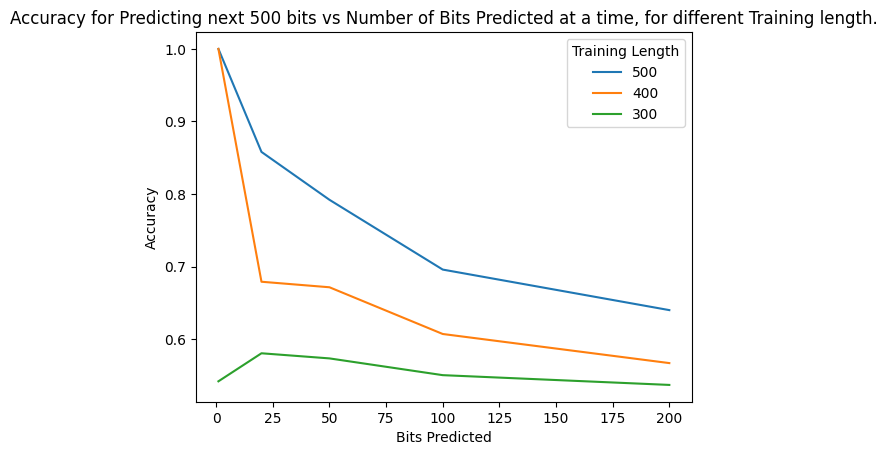

In [9]:
import matplotlib.pyplot as plt
acc_500 = [0.6399359999999992, 0.6958179999999998, 0.7920199999999995, 0.8580199999999999, 1.0]
acc_400 = [0.5669060000000009, 0.6070239999999988, 0.6714399999999999, 0.6790599999999999, 1.0]
acc_300 = [0.5368179999999992, 0.5502819999999998, 0.57338, 0.5804400000000001, 0.5418000000000001]

plt.plot(b_list, acc_500)
plt.plot(b_list, acc_400)
plt.plot(b_list, acc_300)
plt.xlabel("Bits Predicted")
plt.ylabel("Accuracy")
plt.legend(["500", "400", "300"], title="Training Length")
plt.title("Accuracy for Predicting next 500 bits vs Number of Bits Predicted at a time, for different Training length.")

plt.show()

In [17]:
acc2  = find_acc2()

Training Length: 100
Epoch 1/500
1/1 - 1s - loss: 0.6942 - binary_accuracy: 0.5056 - val_loss: 0.6942 - val_binary_accuracy: 0.4938 - 1s/epoch - 1s/step
Epoch 2/500
1/1 - 0s - loss: 0.6762 - binary_accuracy: 0.6742 - val_loss: 0.6970 - val_binary_accuracy: 0.4968 - 107ms/epoch - 107ms/step
Epoch 3/500
1/1 - 0s - loss: 0.6628 - binary_accuracy: 0.6854 - val_loss: 0.7017 - val_binary_accuracy: 0.4997 - 109ms/epoch - 109ms/step
Epoch 4/500
1/1 - 0s - loss: 0.6509 - binary_accuracy: 0.6742 - val_loss: 0.7080 - val_binary_accuracy: 0.5043 - 121ms/epoch - 121ms/step
Epoch 5/500
1/1 - 0s - loss: 0.6399 - binary_accuracy: 0.7079 - val_loss: 0.7158 - val_binary_accuracy: 0.5106 - 116ms/epoch - 116ms/step
Epoch 6/500
1/1 - 0s - loss: 0.6295 - binary_accuracy: 0.7191 - val_loss: 0.7245 - val_binary_accuracy: 0.5104 - 121ms/epoch - 121ms/step
Epoch 7/500
1/1 - 0s - loss: 0.6193 - binary_accuracy: 0.7191 - val_loss: 0.7334 - val_binary_accuracy: 0.5086 - 126ms/epoch - 126ms/step
Epoch 8/500
1/1 - 0

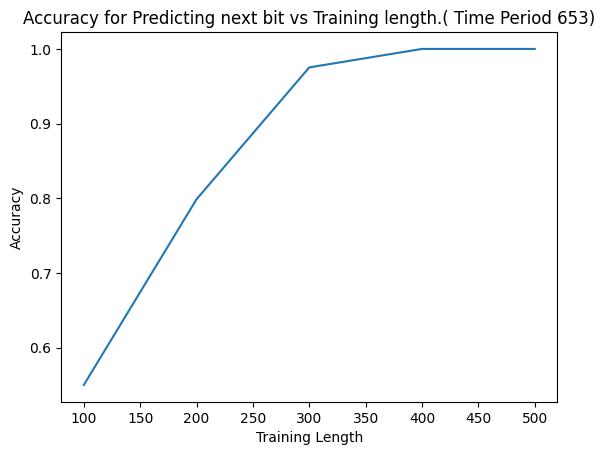

In [19]:
plt.plot(list(range(100,501,100)), acc2)
plt.xlabel("Training Length")
plt.ylabel("Accuracy")
# plt.legend(["500", "400", "300"], title="Training Length")
plt.title("Accuracy for Predicting next bit vs Training length.( Time Period 653)")

plt.show()

In [3]:
acc3 = find_acc3()

Epoch 1/2000


2024-05-06 10:07:44.442659: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-06 10:07:47.821043: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1613] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 9626 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 2080 Ti, pci bus id: 0000:02:00.0, compute capability: 7.5
2024-05-06 10:07:49.839106: I tensorflow/compiler/xla/service/service.cc:173] XLA service 0x559d0fd13280 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-05-06 10:07:49.839150: I tensorflow/compiler/xla/service/service.cc:181]   StreamExecutor device (0): NVIDIA GeForce RTX 2080 Ti, Compute Capability 7.5
2024-05-06 10:07:49.848709: I tensorflow/c

2/2 - 3s - loss: 0.6979 - binary_accuracy: 0.4637 - val_loss: 0.6985 - val_binary_accuracy: 0.5031 - 3s/epoch - 1s/step
Epoch 2/2000
2/2 - 0s - loss: 0.6801 - binary_accuracy: 0.5848 - val_loss: 0.7013 - val_binary_accuracy: 0.4935 - 119ms/epoch - 60ms/step
Epoch 3/2000
2/2 - 0s - loss: 0.6735 - binary_accuracy: 0.5986 - val_loss: 0.7091 - val_binary_accuracy: 0.4919 - 119ms/epoch - 60ms/step
Epoch 4/2000
2/2 - 0s - loss: 0.6681 - binary_accuracy: 0.6159 - val_loss: 0.7181 - val_binary_accuracy: 0.4964 - 116ms/epoch - 58ms/step
Epoch 5/2000
2/2 - 0s - loss: 0.6656 - binary_accuracy: 0.6159 - val_loss: 0.7305 - val_binary_accuracy: 0.5099 - 135ms/epoch - 67ms/step
Epoch 6/2000
2/2 - 0s - loss: 0.6668 - binary_accuracy: 0.6090 - val_loss: 0.7384 - val_binary_accuracy: 0.5071 - 138ms/epoch - 69ms/step
Epoch 7/2000
2/2 - 0s - loss: 0.6654 - binary_accuracy: 0.6021 - val_loss: 0.7339 - val_binary_accuracy: 0.5009 - 139ms/epoch - 69ms/step
Epoch 8/2000
2/2 - 0s - loss: 0.6632 - binary_accura

100%|███████████████████████████████████████████| 30/30 [12:20<00:00, 24.67s/it]


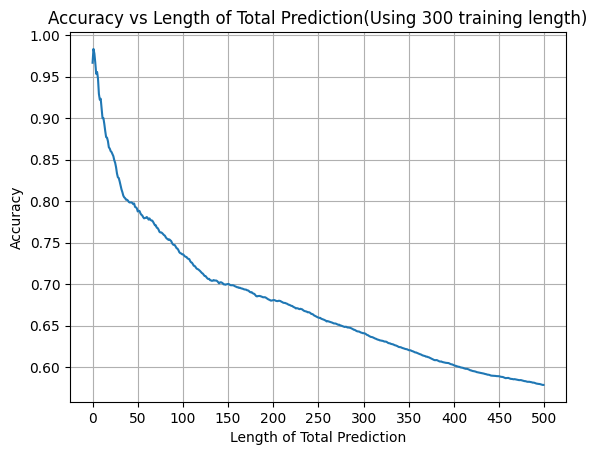

In [12]:
import matplotlib.pyplot as plt
x = list(range(500))
plt.plot(list(range(500)), acc3)
plt.xlabel("Length of Total Prediction")
plt.ylabel("Accuracy")
# plt.legend(["500", "400", "300"], title="Training Length")
plt.xticks(np.arange(min(x), max(x)+3, 50.0))
plt.title("Accuracy vs Length of Total Prediction(Using 300 training length)")
plt.grid()
plt.show()

In [6]:
print(acc3)

[0.96666667 0.98333333 0.97777778 0.96666667 0.95333333 0.95555556
 0.94761905 0.92916667 0.92222222 0.92333333 0.91212121 0.9
 0.9        0.89285714 0.88444444 0.87708333 0.87647059 0.87222222
 0.86491228 0.86333333 0.86031746 0.85909091 0.85652174 0.85416667
 0.84933333 0.84615385 0.84074074 0.83333333 0.82873563 0.82777778
 0.82365591 0.81875    0.81414141 0.81078431 0.80666667 0.80462963
 0.8036036  0.80175439 0.8017094  0.80083333 0.79918699 0.7984127
 0.79844961 0.79848485 0.79777778 0.79637681 0.79716312 0.79305556
 0.79251701 0.79133333 0.7875817  0.78846154 0.78805031 0.78518519
 0.78363636 0.7827381  0.78070175 0.77931034 0.77966102 0.78
 0.78087432 0.77956989 0.77777778 0.77916667 0.7774359  0.77676768
 0.77661692 0.775      0.77294686 0.77095238 0.77089202 0.76805556
 0.76757991 0.76576577 0.76311111 0.7622807  0.76233766 0.76153846
 0.76033755 0.75916667 0.75843621 0.75650407 0.75502008 0.75436508
 0.75333333 0.75387597 0.75287356 0.75189394 0.7494382  0.74777778
 0.747252